In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [31]:
df = pd.read_csv('heart_v2.csv')
df.head()

age  sex   BP  cholestrol  heart disease
0   70    1  130         322              1
1   67    0  115         564              0
2   57    1  124         261              1
3   64    1  128         263              0
4   74    0  120         269              0

In [32]:
df.shape

(270, 5)

In [33]:
X = df.drop('heart disease', axis=1)
y = df['heart disease']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

In [35]:
X_train.shape

(189, 4)

In [36]:
X_test.shape

(81, 4)

In [37]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(random_state=42, max_depth= 5, n_estimators=100, oob_score= True)

In [38]:
%%time
classifier_rf.fit(X_train, y_train)

CPU times: user 58.3 ms, sys: 3.63 ms, total: 62 ms
Wall time: 61.7 ms


RandomForestClassifier(max_depth=5, oob_score=True, random_state=42)

In [39]:
classifier_rf.oob_score_

0.656084656084656

In [40]:
classifier_rf.score(X_test, y_test)

0.654320987654321

# ''Grid Search for Parameter Finetuning''

In [41]:
rf = RandomForestClassifier(random_state=42)

In [42]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [43]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=params, cv=4, n_jobs=-1, verbose=1, scoring="accuracy")

In [44]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits
CPU times: user 268 ms, sys: 31 ms, total: 299 ms
Wall time: 4.9 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [45]:
grid_search.best_score_

0.6985815602836879

In [46]:
rf_best=grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=5, min_samples_leaf=10, n_estimators=10,
                       random_state=42)

Visualizing the decision tree with index 9 in the given random forest

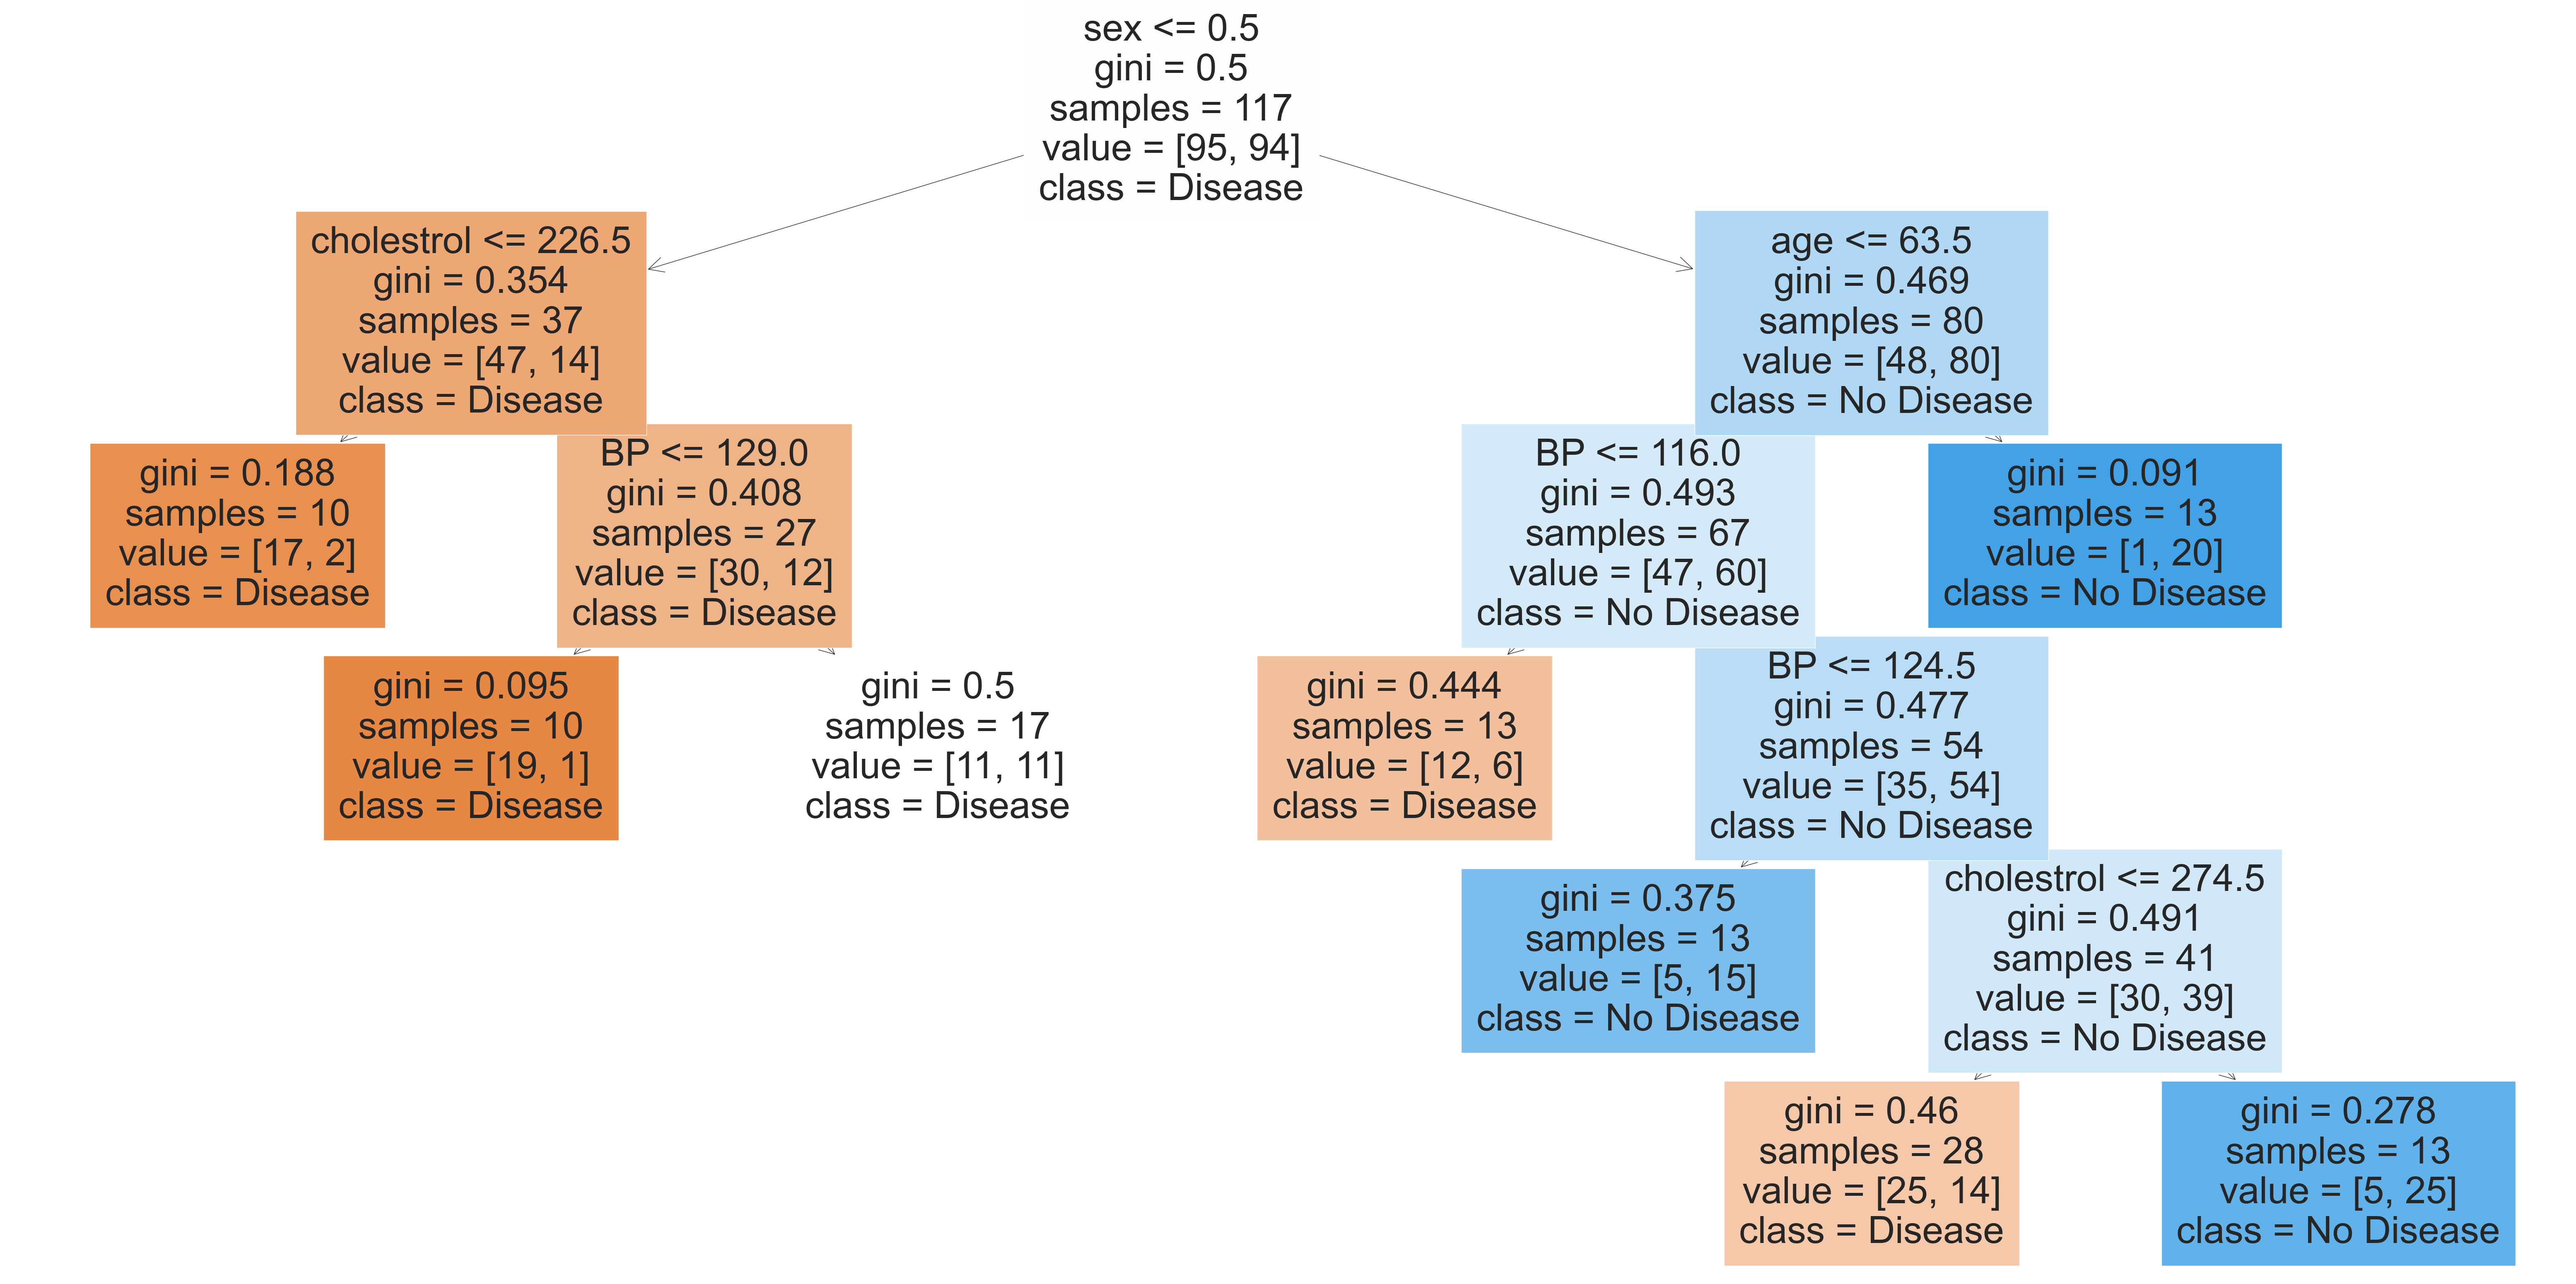

In [66]:
from sklearn.tree import plot_tree
plt.figure(figsize=(80, 40))
plot_tree(rf_best.estimators_[9], feature_names=X.columns,class_names=['Disease', "No Disease"],filled=True)
plt.show()

Visualizing the decision tree with index 7 in the given random forest

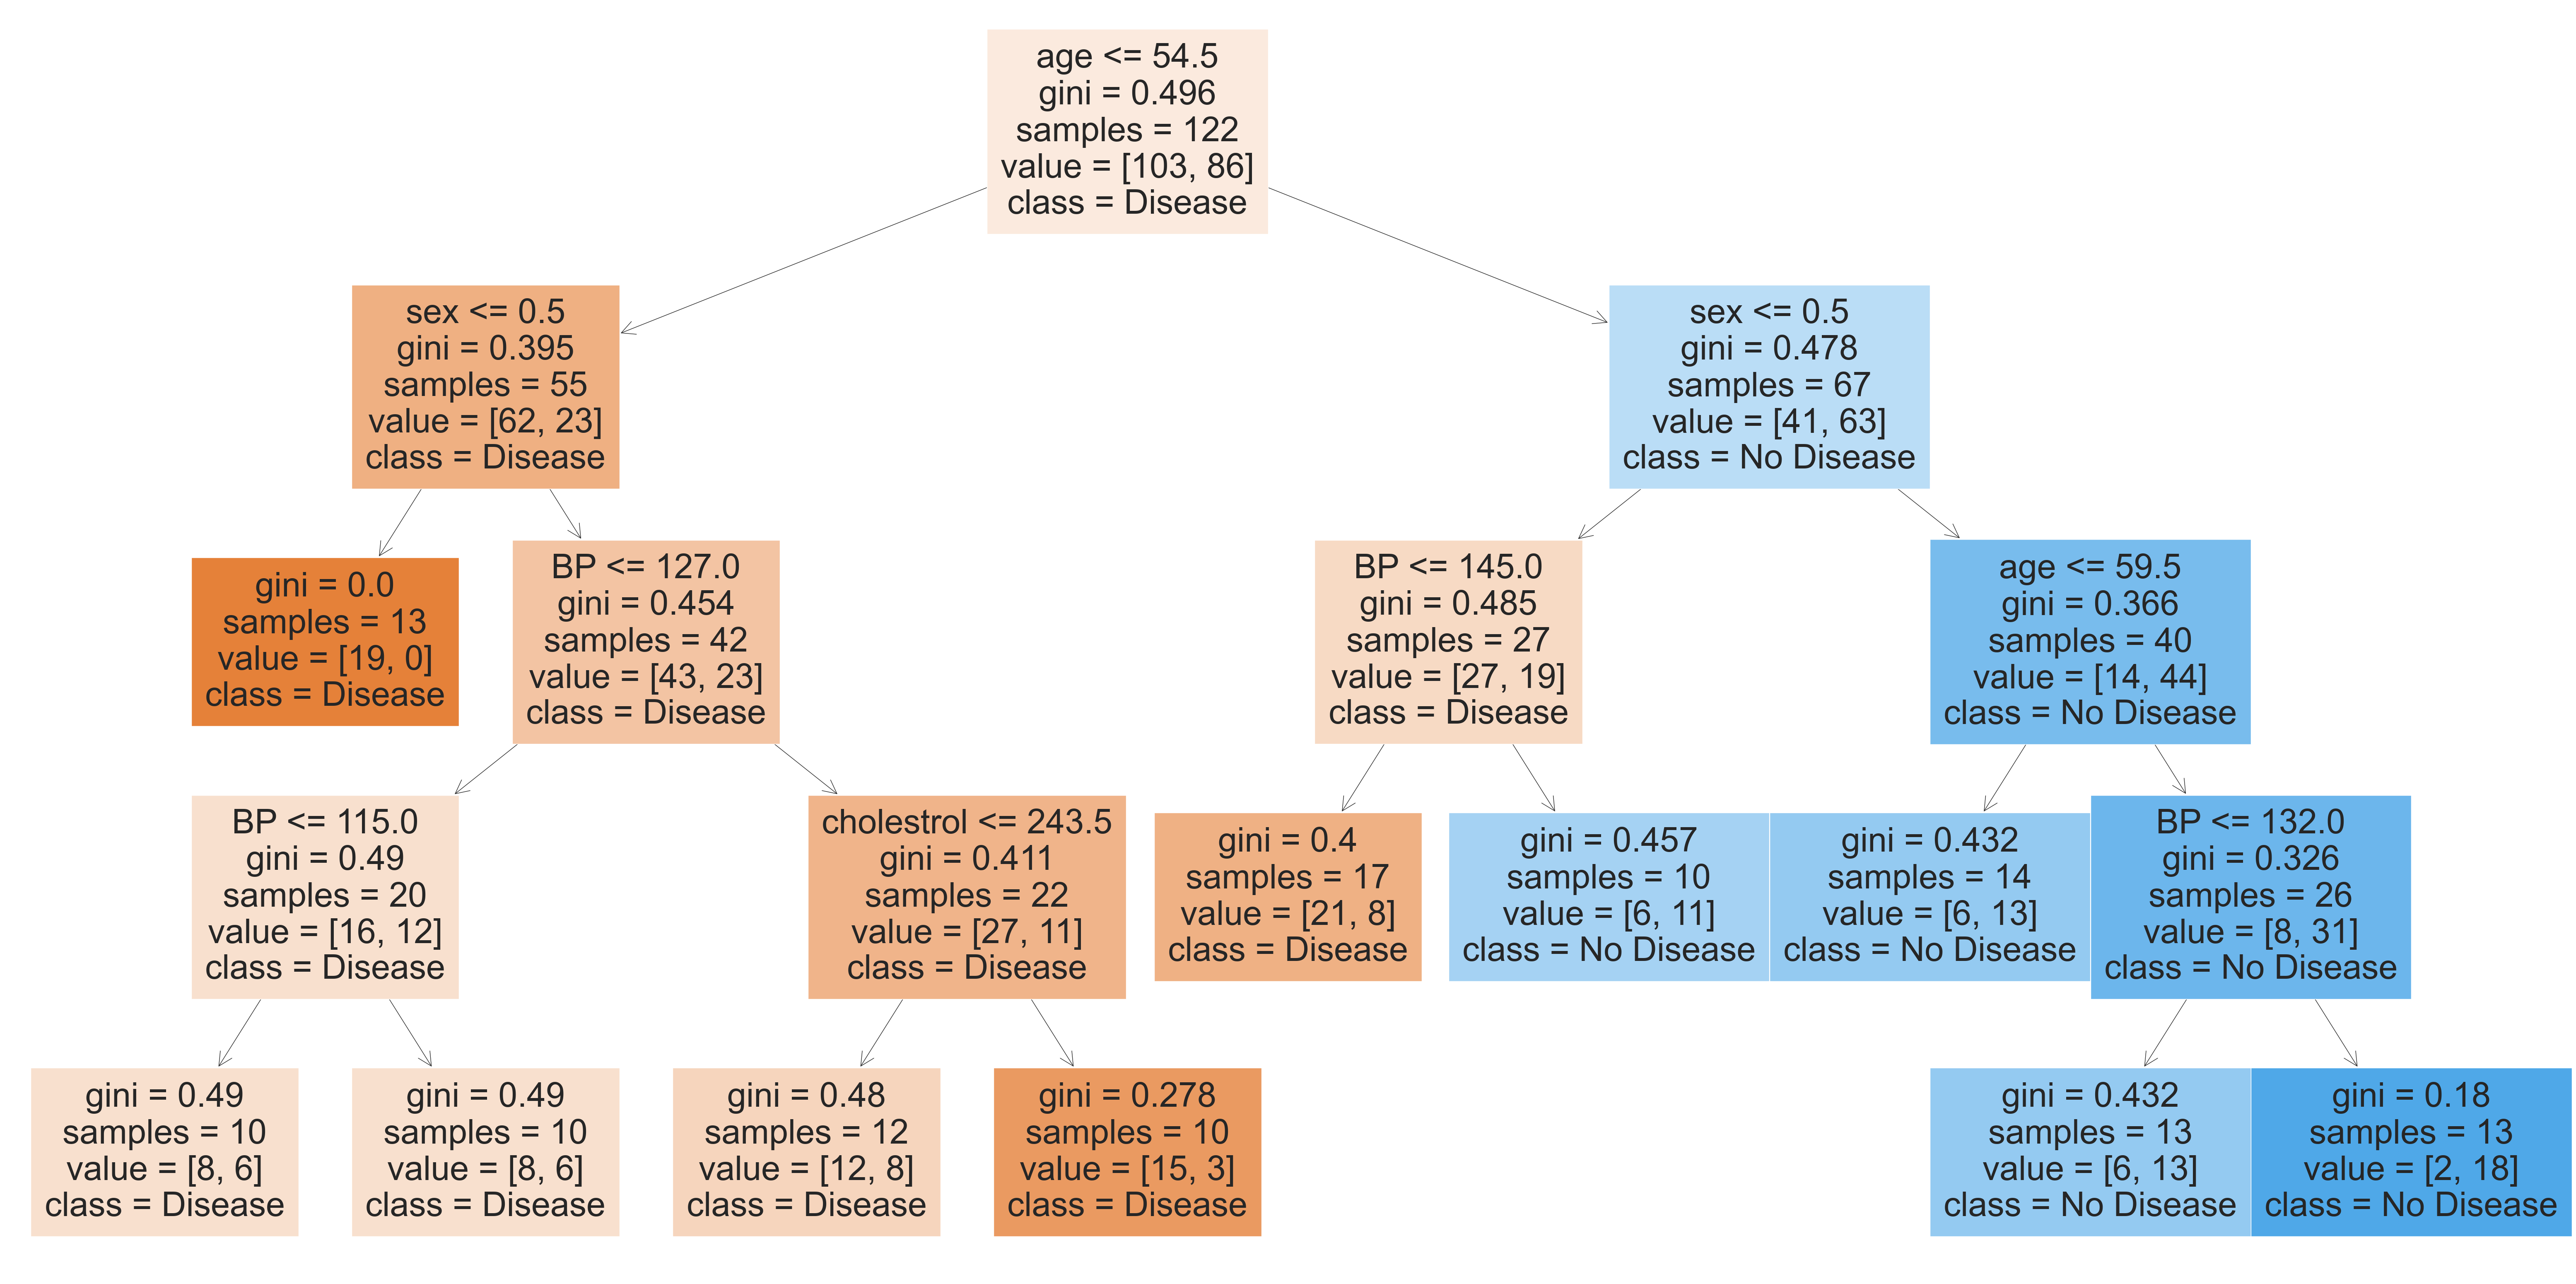

In [50]:
from sklearn.tree import plot_tree
plt.figure(figsize=(80, 40))
plot_tree(rf_best.estimators_[7], feature_names=X.columns,class_names=['Disease', "No Disease"],filled=True)
plt.show()

Finding the feature importance

In [51]:
rf_best.feature_importances_

array([0.46128487, 0.2180848 , 0.13174619, 0.18888413])

In [52]:
imp_df=pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

In [53]:
imp_df.sort_values(by="Imp", ascending=False)

Varname       Imp
0         age  0.461285
1         sex  0.218085
3  cholestrol  0.188884
2          BP  0.131746

# "Random Search for Hyperparameter Finetuning"

In [55]:
from scipy.stats import randint
rs_space={'max_depth':list(np.arange(10, 100, step=10))+[None],
          'n_estimators':np.arange(10, 500, step=50),
          'max_features':randint(1,7),
          'criterion':['gini','entropy'],
          'min_samples_leaf':randint(1,4),
          'min_samples_split':np.arange(2, 10, step=2)
          }

In [58]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_random = RandomizedSearchCV(rf, rs_space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=4)

In [59]:
%%time
model_random = rf_random.fit(X_train, y_train)

CPU times: user 301 ms, sys: 177 ms, total: 477 ms
Wall time: 12 s


In [60]:
model_random.best_params_

{'criterion': 'entropy',
 'max_depth': 60,
 'max_features': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 310}

In [61]:
model_random.best_score_

0.6881648936170213

In [62]:
rf_best1 = model_random.best_estimator_
rf_best1

RandomForestClassifier(criterion='entropy', max_depth=60, max_features=1,
                       min_samples_leaf=2, min_samples_split=6,
                       n_estimators=310, n_jobs=-1, random_state=42)

Visualizing the decision tree with index 9 in the given random forest

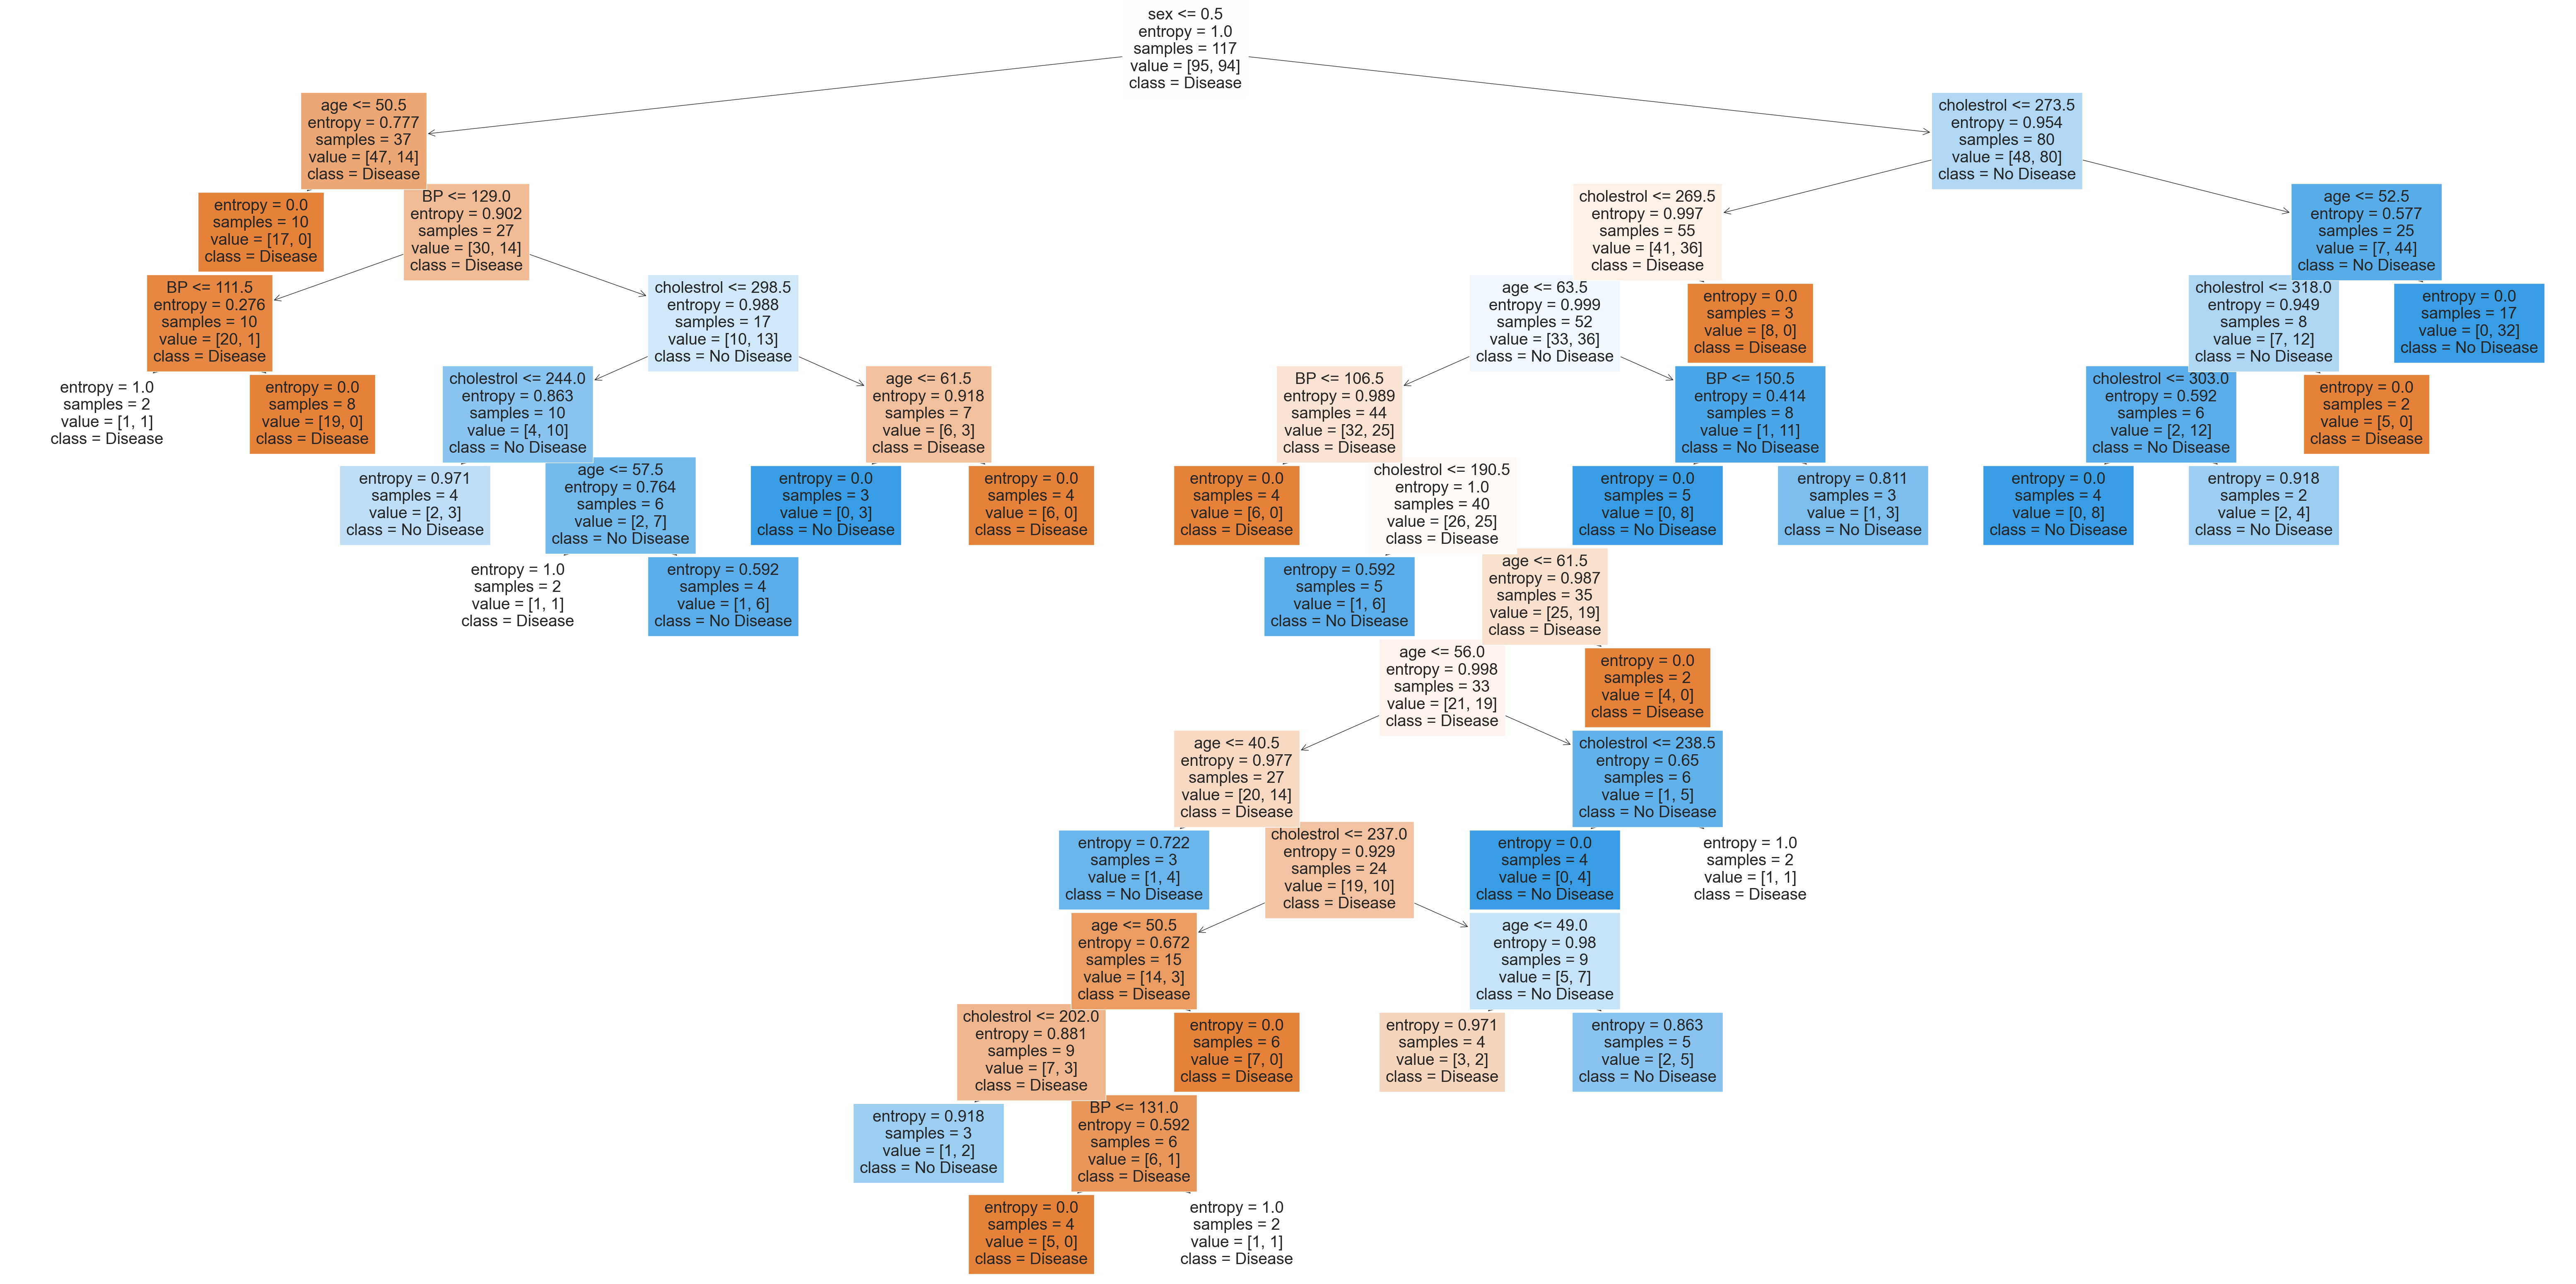

In [65]:
from sklearn.tree import plot_tree
plt.figure(figsize=(80,40))
plot_tree(rf_best1.estimators_[9], feature_names = X.columns,class_names=['Disease', "No Disease"],filled=True)
plt.show()

# "Normal RF Vs. GridSearch RF Vs. RandomSearch RF"

In [67]:
from sklearn.metrics import confusion_matrix
y_pred = rf_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[33, 16],
       [14, 18]])

Text(97.72222222222221, 0.5, 'Truth')

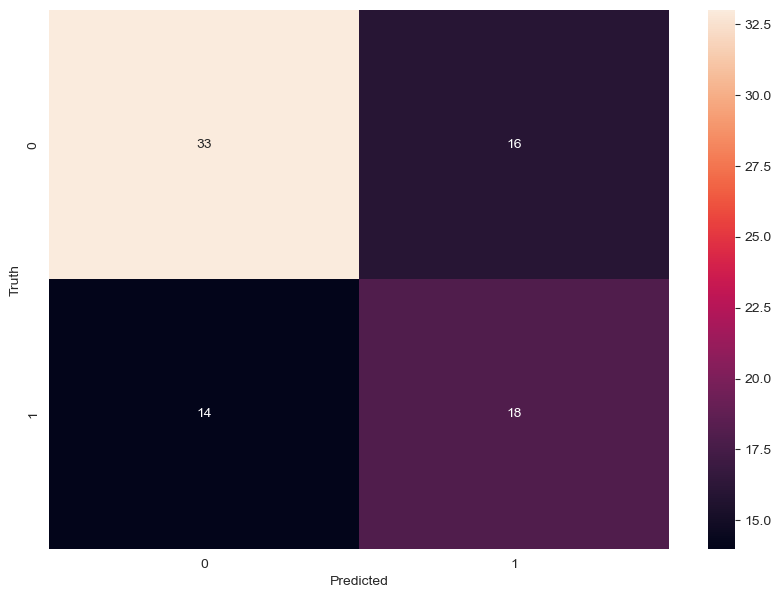

In [70]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [71]:
from sklearn.metrics import confusion_matrix
y_pred1 = rf_best1.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred)
cm1

array([[33, 16],
       [14, 18]])

Text(97.72222222222221, 0.5, 'Truth')

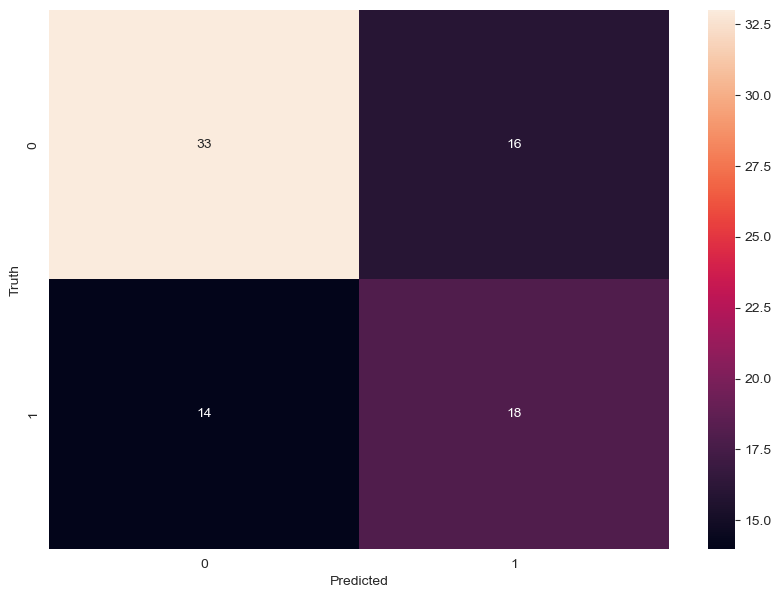

In [72]:
plt.figure(figsize=(10,7))
sns.heatmap(cm1, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.67      0.69        49
           1       0.53      0.56      0.55        32

    accuracy                           0.63        81
   macro avg       0.62      0.62      0.62        81
weighted avg       0.63      0.63      0.63        81


In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74        49
           1       0.60      0.56      0.58        32

    accuracy                           0.68        81
   macro avg       0.66      0.66      0.66        81
weighted avg       0.68      0.68      0.68        81


In [75]:
y_pred2 = classifier_rf.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred2)
cm2

array([[36, 13],
       [15, 17]])

Text(97.72222222222221, 0.5, 'Truth')

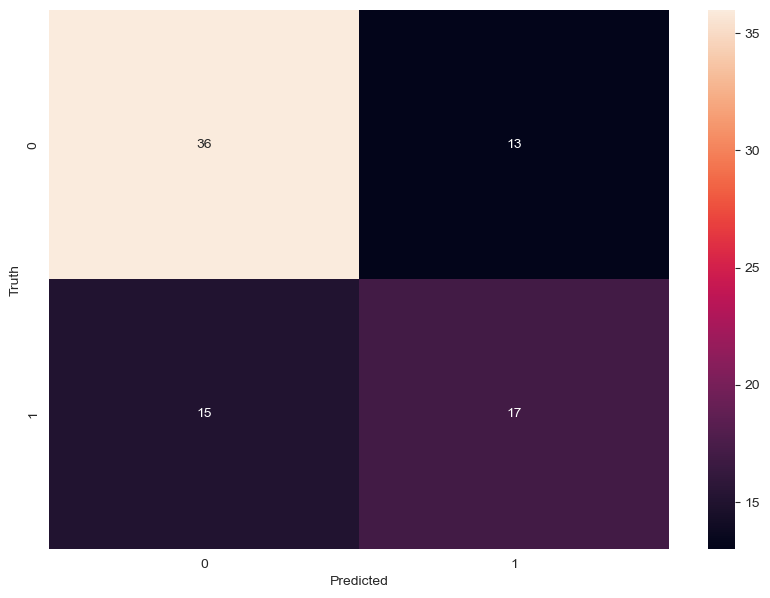

In [76]:
plt.figure(figsize=(10,7))
sns.heatmap(cm2, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')